In [49]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices
from utils.generate_uncertainty_maps import UncertaintyMapsGenerator, ImageUncertainties

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 0

# baseline: 
exp_base = {2: "20180328_10_53_16_dcnnv1_150000E_lr2e02",
            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
exp_base_model = os.path.join(LOG_DIR, exp_base[TEST_FOLD])
# Jelmers base model with brier-score
# Fold 2: 20180329_08_02_33_dcnnv1_150000E_lr2e04
# Fold 0: 20180331_09_48_22_dcnnv1_150000E_lr2e02
exp_base_bs = {2: "20180329_08_02_33_dcnnv1_150000E_lr2e04",
               0: "20180331_09_48_22_dcnnv1_150000E_lr2e02"}
exp_base_bs_model = os.path.join(LOG_DIR, exp_base_bs[TEST_FOLD])
# MC dropout models
# Fold 2: 20180328_10_54_36_dcnn_mcv1_150000E_lr2e02
# Fold 0: 20180330_09_56_01_dcnn_mcv1_150000E_lr2e02
exp_mc005 = {2: "20180328_10_54_36_dcnn_mcv1_150000E_lr2e02",
             0: "20180330_09_56_01_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_model = os.path.join(LOG_DIR, exp_mc005[TEST_FOLD])
# Fold 2: 20180329_08_04_12_dcnn_mcv1_150000E_lr2e04
# Fold 0: 20180331_09_49_14_dcnn_mcv1_150000E_lr2e02
exp_mc005_bs = {2: "20180329_08_04_12_dcnn_mcv1_150000E_lr2e04",
                0: "20180331_09_49_14_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_bs_model = os.path.join(LOG_DIR, exp_mc005_bs[TEST_FOLD])

# Fold 2: 20180328_10_54_55_dcnn_mcv1_150000E_lr2e02
# Fold 0: 20180330_09_56_15_dcnn_mcv1_150000E_lr2e02
exp_mc01 = {2: "20180328_10_54_55_dcnn_mcv1_150000E_lr2e02",
            0: "20180330_09_56_15_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_model = os.path.join(LOG_DIR, exp_mc01[TEST_FOLD])
# Fold 2: 20180329_08_03_29_dcnn_mcv1_150000E_lr2e04
# Fold 0: 20180331_09_48_48_dcnn_mcv1_150000E_lr2e02
exp_mc01_bs = {2: "20180329_08_03_29_dcnn_mcv1_150000E_lr2e04",
               0: "20180331_09_48_48_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_bs_model = os.path.join(LOG_DIR, exp_mc01_bs[TEST_FOLD])

# Fold 2: 20180329_08_26_03_dcnn_mcv1_150000E_lr2e02
# Fold 0: 20180404_09_06_37_dcnn_mcv1_150000E_lr2e02
exp_mc02 = {2: "20180329_08_26_03_dcnn_mcv1_150000E_lr2e02",
            0: "20180404_09_06_37_dcnn_mcv1_150000E_lr2e02"}
exp_mc02_model = os.path.join(LOG_DIR, exp_mc02[TEST_FOLD])
# Fold 2: 20180331_10_03_03_dcnn_mcv1_150000E_lr2e04
# Fold 0: 20180404_09_12_48_dcnn_mcv1_150000E_lr2e04
exp_mc02_bs = {2: "20180331_10_03_03_dcnn_mcv1_150000E_lr2e04",
               0: "20180404_09_12_48_dcnn_mcv1_150000E_lr2e04"}
exp_mc02_bs_model = os.path.join(LOG_DIR, exp_mc02_bs[TEST_FOLD])

# Fold 2: 20180329_08_42_47_dcnn_mcv1_150000E_lr2e02
# Fold 0: 20180404_09_05_00_dcnn_mcv1_150000E_lr2e02
exp_mc03 = {2: "20180329_08_42_47_dcnn_mcv1_150000E_lr2e02",
            0: "20180404_09_05_00_dcnn_mcv1_150000E_lr2e02"}
exp_mc03_model = os.path.join(LOG_DIR, exp_mc03[TEST_FOLD])
# Fold 2: 20180331_10_02_23_dcnn_mcv1_150000E_lr2e04
# Fold 0: 20180405_08_32_07_dcnn_mcv1_150000E_lr2e04
exp_mc03_bs = {2: "20180331_10_02_23_dcnn_mcv1_150000E_lr2e04",
               0: "20180405_08_32_07_dcnn_mcv1_150000E_lr2e04"}
exp_mc03_bs_model = os.path.join(LOG_DIR, exp_mc03_bs[TEST_FOLD])

In [3]:
exper_mc005 = ExperimentHandler.load_experiment(exp_mc005_model)
exper_hdl_mc005 = ExperimentHandler(exper_mc005, use_logfile=False)
exper_hdl_mc005.set_root_dir(ROOT_DIR)
exper_hdl_mc005.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc005.exper.run_args.fold_ids[0],
    exper_hdl_mc005.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005.exper.model_name))

exper_mc005_bs = ExperimentHandler.load_experiment(exp_mc005_bs_model)
exper_hdl_mc005_bs = ExperimentHandler(exper_mc005_bs, use_logfile=False)
exper_hdl_mc005_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc005_bs.set_model_name("MC-BS-dropout fold-{} (p={})".format(
    exper_hdl_mc005_bs.exper.run_args.fold_ids[0],
    exper_hdl_mc005_bs.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_bs.exper.model_name))

exper_mc01 = ExperimentHandler.load_experiment(exp_mc01_model)
exper_hdl_mc01 = ExperimentHandler(exper_mc01, use_logfile=False)
exper_hdl_mc01.set_root_dir(ROOT_DIR)
exper_hdl_mc01.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc01.exper.run_args.fold_ids[0],
    exper_hdl_mc01.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01.exper.model_name))

exper_mc01_bs = ExperimentHandler.load_experiment(exp_mc01_bs_model)
exper_hdl_mc01_bs = ExperimentHandler(exper_mc01_bs, use_logfile=False)
exper_hdl_mc01_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc01_bs.set_model_name("MC-BS-dropout fold-{} (p={})".format(
    exper_hdl_mc01_bs.exper.run_args.fold_ids[0],
    exper_hdl_mc01_bs.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_bs.exper.model_name))


exper_mc02 = ExperimentHandler.load_experiment(exp_mc02_model)
exper_hdl_mc02 = ExperimentHandler(exper_mc02, use_logfile=False)
exper_hdl_mc02.set_root_dir(ROOT_DIR)
exper_hdl_mc02.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc02.exper.run_args.fold_ids[0],
    exper_hdl_mc02.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc02.exper.model_name))

exper_mc02_bs = ExperimentHandler.load_experiment(exp_mc02_bs_model)
exper_hdl_mc02_bs = ExperimentHandler(exper_mc02_bs, use_logfile=False)
exper_hdl_mc02_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc02_bs.set_model_name("MC-BS-dropout fold-{} (p={})".format(
    exper_hdl_mc02_bs.exper.run_args.fold_ids[0],
    exper_hdl_mc02_bs.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc02_bs.exper.model_name))


exper_mc03 = ExperimentHandler.load_experiment(exp_mc03_model)
exper_hdl_mc03 = ExperimentHandler(exper_mc03, use_logfile=False)
exper_hdl_mc03.set_root_dir(ROOT_DIR)
exper_hdl_mc03.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl_mc03.exper.run_args.fold_ids[0],
    exper_hdl_mc03.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc03.exper.model_name))


exper_mc03_bs = ExperimentHandler.load_experiment(exp_mc03_bs_model)
exper_hdl_mc03_bs = ExperimentHandler(exper_mc03_bs, use_logfile=False)
exper_hdl_mc03_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc03_bs.set_model_name("MC-BS-dropout fold-{} (p={})".format(
        exper_hdl_mc03_bs.exper.run_args.fold_ids[0],
        exper_hdl_mc03_bs.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc03_bs.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=15, use_cuda=True, load_val=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180331_09_49_14_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-BS-dropout fold-0 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_15_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.1)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180331_09_48_48_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-BS-dropout fold-0 (p=0.1)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180404_09_06_37_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.2)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180404_09_12_48_dcnn_mcv1_150000E_lr2e04/stats/exper_stats.dll
Model name MC-BS-dropout fold-0 (p=0.2)
Load experiment from /home/jo

  7%|▋         | 1/15 [00:00<00:07,  1.99it/s]/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 15/15 [00:07<00:00,  1.91it/s]

INFO - Successfully loaded 15 ED/ES patient pairs


In [4]:
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
exp_model = os.path.join(LOG_DIR, "20180330_09_56_01_dcnn_mcv1_150000E_lr2e02")
exper = ExperimentHandler.load_experiment(exp_model)
exper_hdl = ExperimentHandler(exper, use_logfile=False)
exper_hdl.set_root_dir(ROOT_DIR)
exper_hdl.set_model_name("MC-dropout fold-{} (p={})".format(exper_hdl.exper.run_args.fold_ids[0],
    exper_hdl.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl.exper.model_name))
exper_handler = exper_hdl

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Model name MC-dropout fold-0 (p=0.05)


In [54]:
from utils.generate_uncertainty_maps import UncertaintyMapsGenerator
mc_samples = 5
exper_handler = exper_hdl_mc005
exper_handler.logger = None

maps_generator = UncertaintyMapsGenerator(exper_handler, test_set=None, verbose=False, mc_samples=mc_samples,
                                          store_test_results=True, u_threshold=0.1)
maps_generator(clean_up=True, do_save=True)

  0%|          | 0/75 [00:00<?, ?it/s]

INFO - Testhandler - >>> Search in train-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images_iso/*patient*.mhd <<<
INFO - File list contains 150 files, hence 75 patients


  0%|          | 0/75 [00:00<?, ?it/s]

INFO - Successfully loaded 75 ED/ES patient pairs
INFO - loading model MC-dropout fold-0 (p=0.05)
INFO - Starting to generate uncertainty maps for 75 images using 5 samples and u-threshold 0.10
NOTE: first cleaning up previous generated uncertainty maps!


100%|██████████| 75/75 [09:00<00:00,  7.21s/it]

INFO - Successfully saved 75 maps to /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/u_maps
INFO - Saved results to /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/stats/test_results_75imgs_mc5_folds0_ep150000.dll
INFO - Total duration of generation process 540.61 secs


In [ ]:
print(maps_generator.test_results.image_names)
print(u_stats.raw_uncertainties['patient016']["stddev"][0, 1, 0])
print(u_stats.norm_uncertainty_per_cls['patient016'][0, 1])
for i, j in img_outliers.outlier_slices.keys():
    if i == 'patient016':
        print(tuple((i, j)))
        print(img_outliers.outlier_slices[tuple((i, j))])

In [57]:
u_stats = ImageUncertainties.create_from_testresult(maps_generator.test_results)
img_outliers = u_stats.get_outlier_obj(use_high_threshold=True)
img_outliers.create_dataset(dataset, train=True)
print("Number of outlier slices {}. Dataset contains {} slices in "
              "total".format(len(img_outliers.outlier_slices), len(img_outliers.images)))

Number of outlier slices 340. Dataset contains 1360 slices in total


In [65]:
model = exper_handler.load_checkpoint(verbose=False, drop_prob=exper_handler.exper.run_args.drop_prob,
                                               checkpoint=None)

In [66]:
exper_handler.create_outlier_dataset(dataset, model=model, checkpoint=None, mc_samples=5, u_threshold=0.1,
                                     do_save=True, use_high_threshold=True, use_train_set=True)

0it [00:00, ?it/s]
0it [00:00, ?it/s]

INFO - Testhandler - >>> Search in train-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images_iso_iso/*patient*.mhd <<<
INFO - File list contains 0 files, hence 0 patients
INFO - Successfully loaded 0 ED/ES patient pairs
INFO - Starting to generate uncertainty maps for 0 images using 5 samples and u-threshold 0.10
NOTE: first cleaning up previous generated uncertainty maps!
INFO - Successfully saved 0 maps to /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/u_maps
INFO - Saved results to /home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/stats/test_results_0imgs_mc5_folds0_ep150000.dll
INFO - Total duration of generation process 0.01 secs



/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

('patientID_range ', ['patient001', 'patient002'])
--------- Outlier slices -------------
[1]


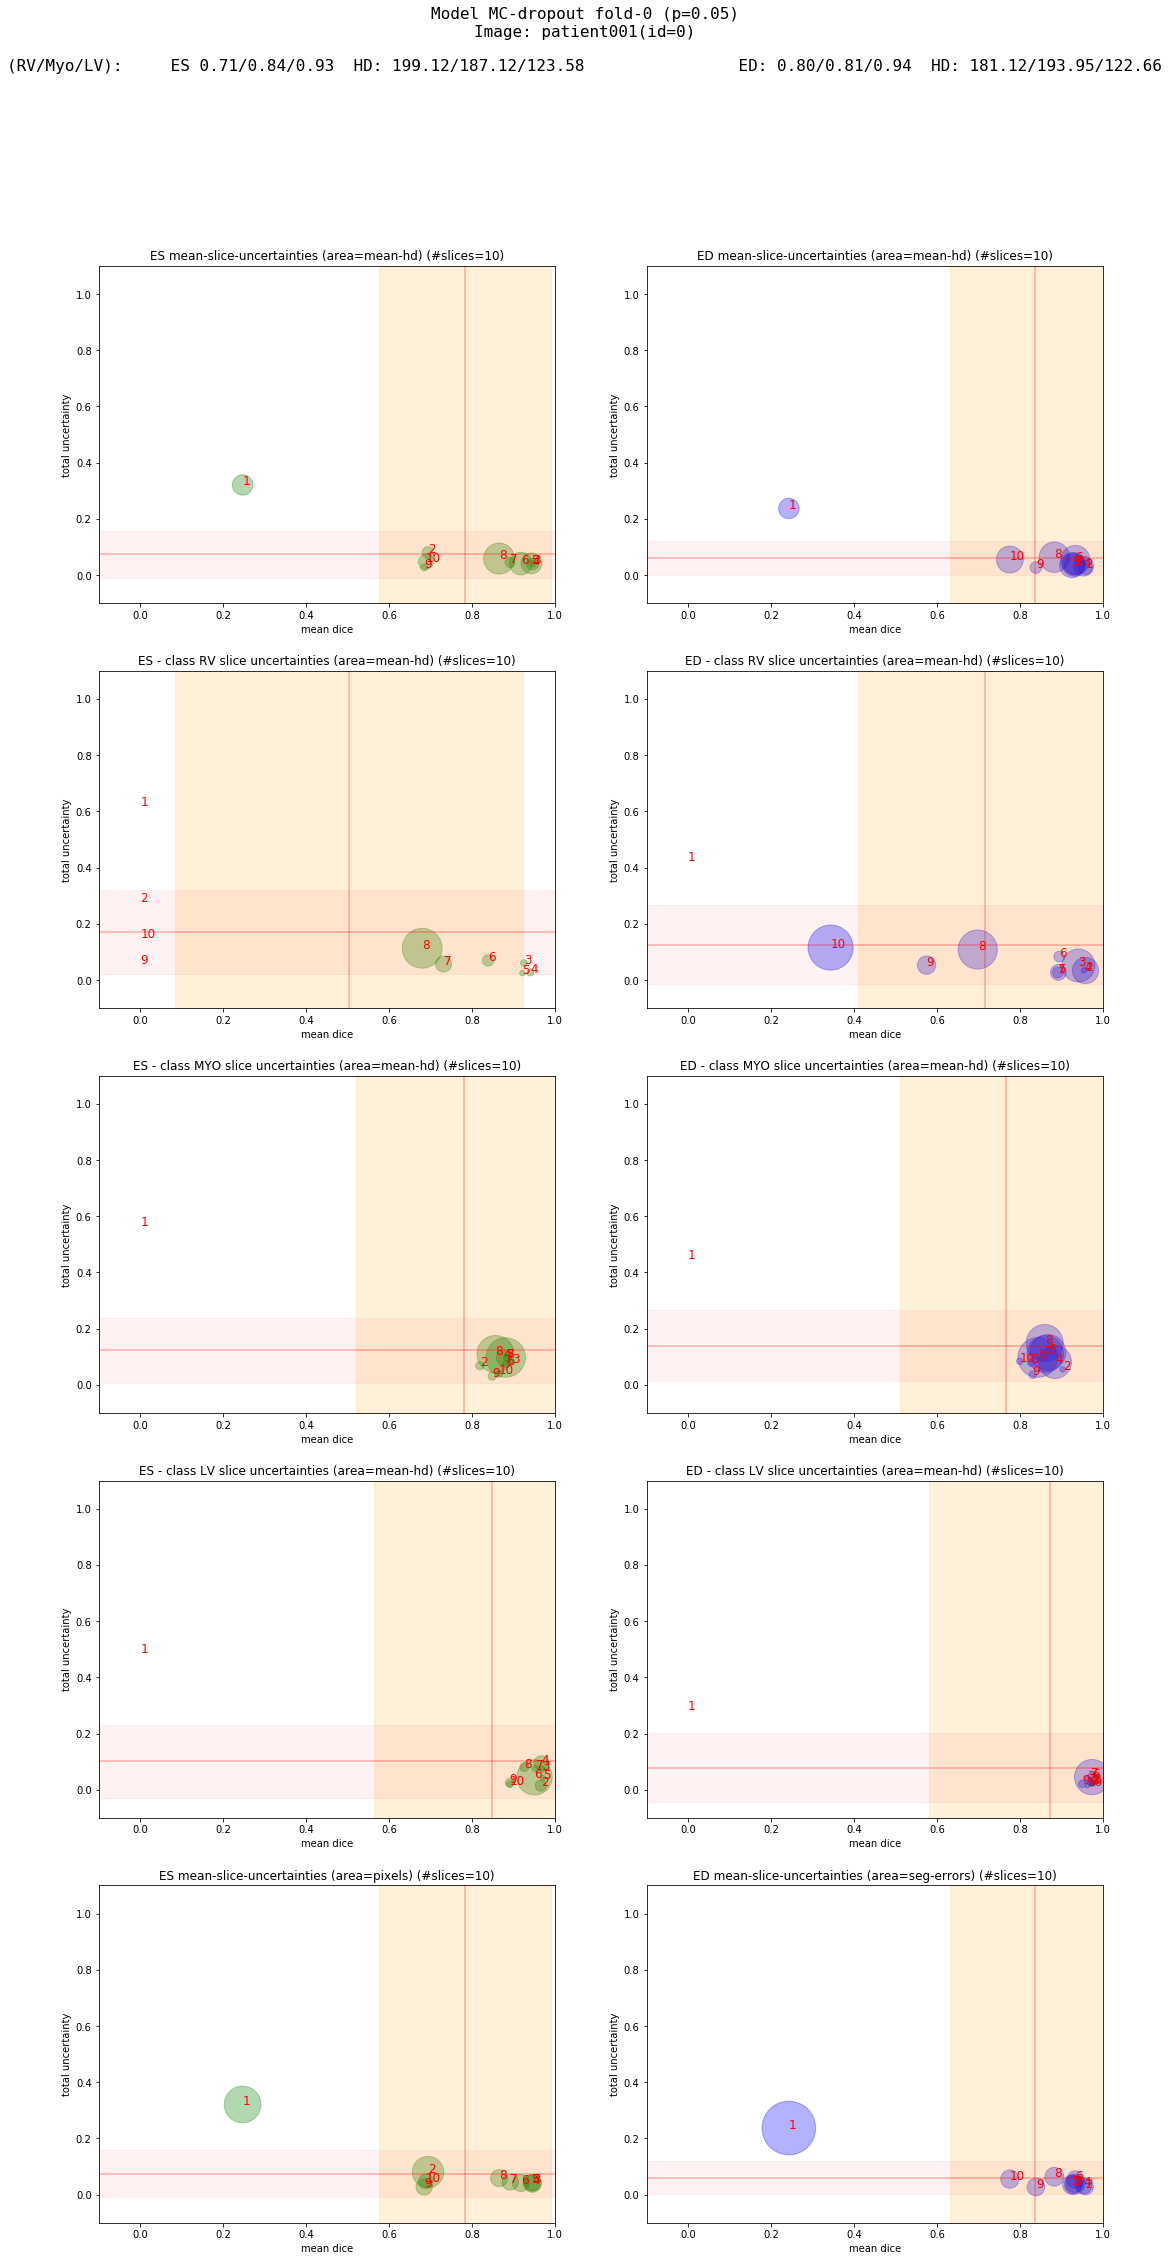

--------- Outlier slices -------------
[10]


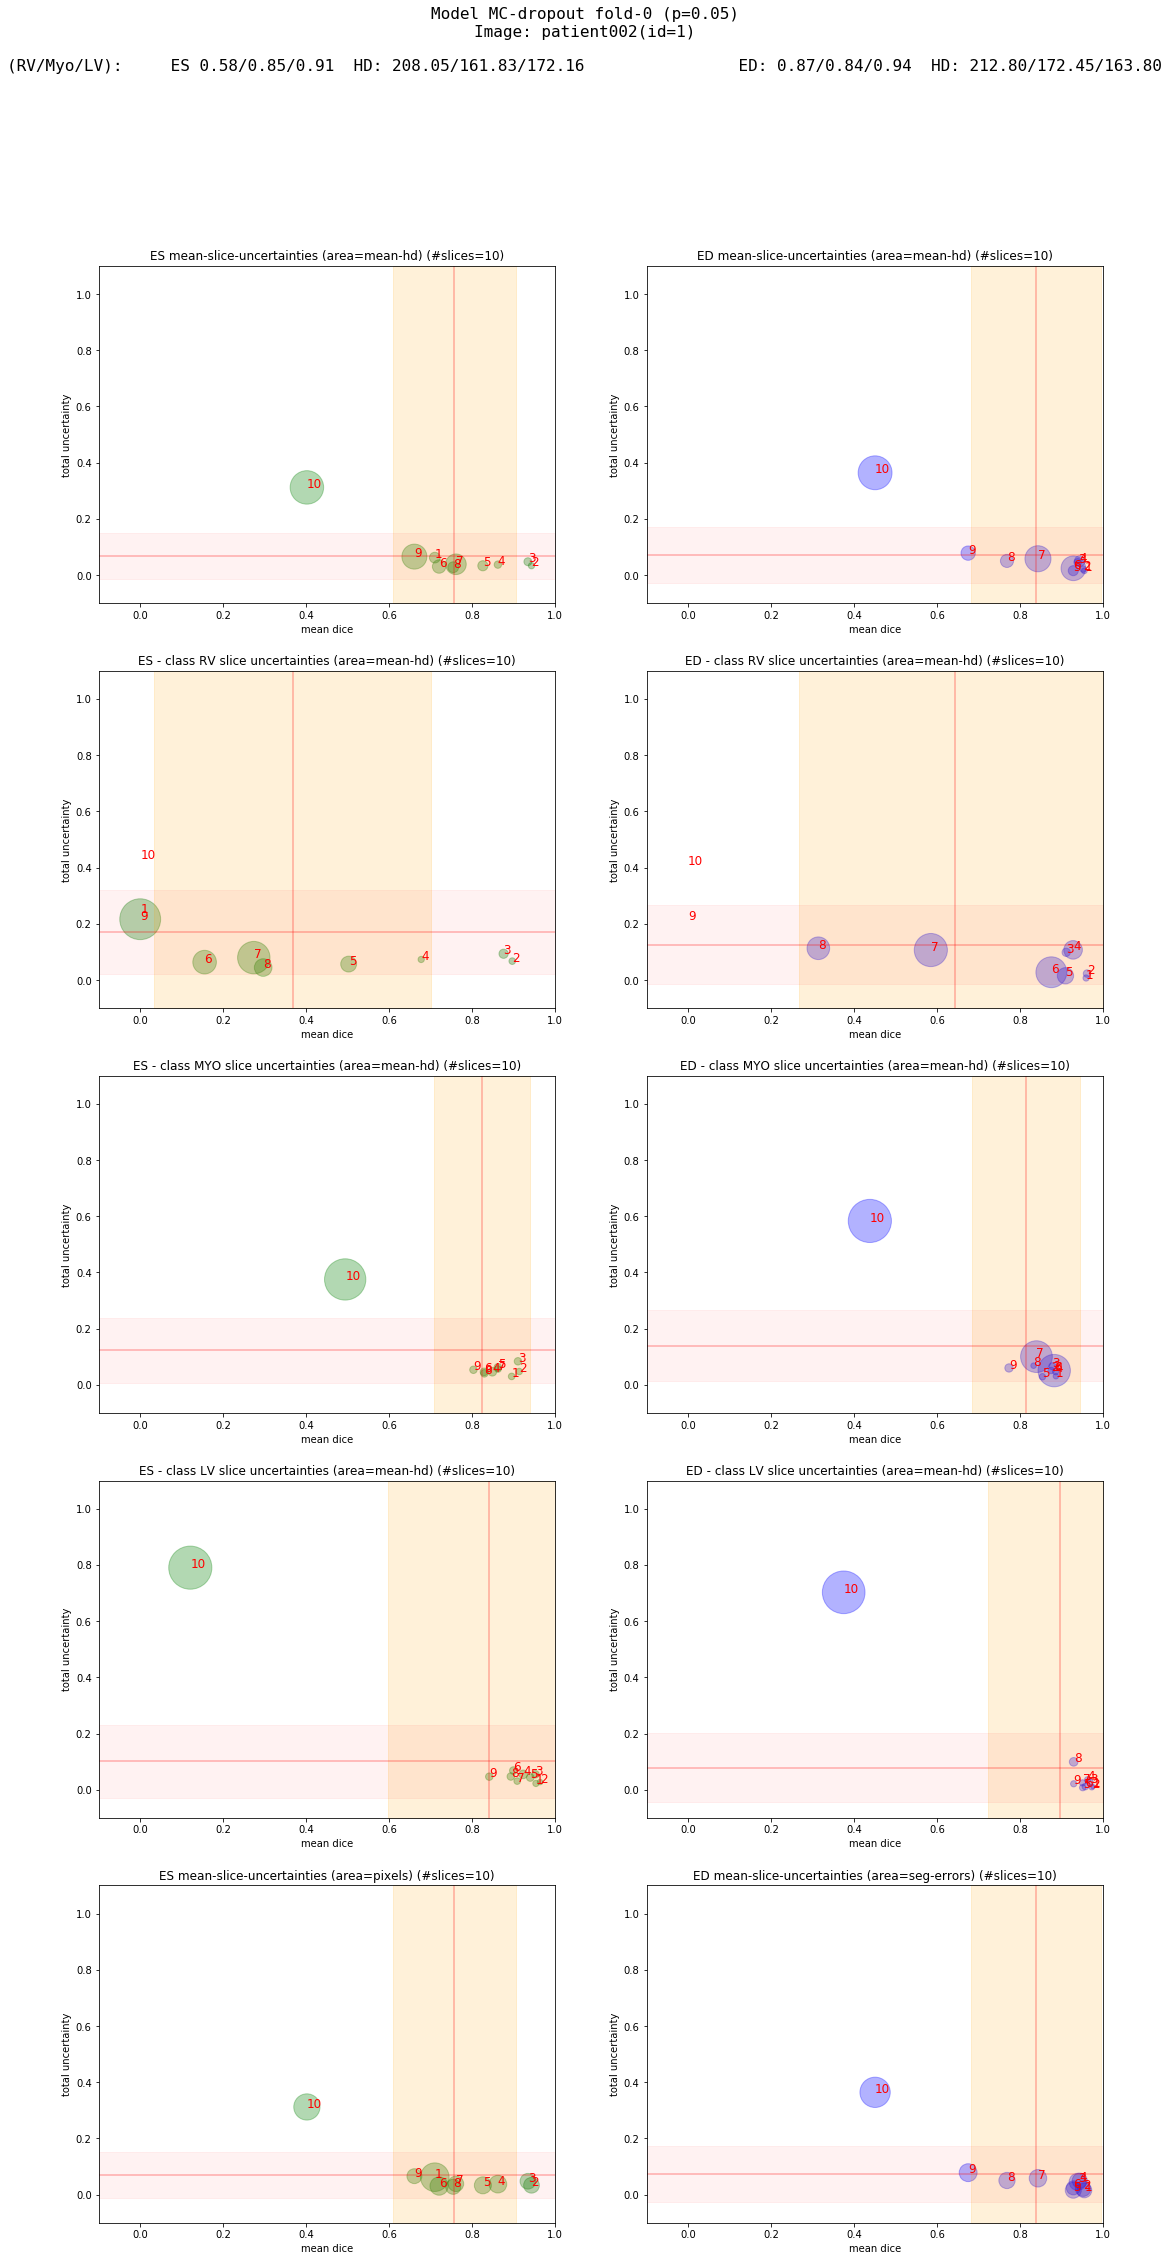

In [62]:
exper_handler.test_results = maps_generator.test_results

image_range = [0,1]
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=False, do_show=True, u_type=u_type,
               use_high_threshold=True)

In [31]:
from utils.generate_uncertainty_maps import UncertaintyMapsGenerator

img_uncertainties = ImageUncertainties.load_uncertainty_maps(exper_handler=exper_handler)

/home/jorg/repository/dcnn_acdc/logs/20180330_09_56_01_dcnn_mcv1_150000E_lr2e02/u_maps/*_umaps.npz


In [7]:
dataset = ACDC2017DataSet(exper_hdl.exper.config, search_mask=config.dflt_image_name + ".mhd",
                              fold_ids=exper_hdl.exper.run_args.fold_ids, preprocess=False,
                              debug=exper_hdl.exper.run_args.quick_run)

  1%|▏         | 1/75 [00:00<00:10,  6.92it/s]

INFO - Using folds ['0'] - busy loading images/references...this may take a while!
INFO - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images_iso/*patient*.mhd <<<


100%|██████████| 25/25 [00:01<00:00, 13.41it/s]

INFO - Using folds ['0'] - loaded 200 files: 2892 slices in train set, 912 slices in validation set


In [ ]:
test_set = ACDC2017TestHandler(exper_config=config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[0],
                               debug=False, batch_size=15, use_cuda=True, load_train=True, load_val=True)

In [ ]:
# display predicted scores by the model as a contour plot
x = np.linspace(0, heat_map.shape[0])
y = np.linspace(0, heat_map.shape[1])
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()_mc005

In [ ]:
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()